In [1]:
%matplotlib notebook
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [73]:
#读取数据
veh_info = pd.read_csv('./file_save/veh_info.csv')
veh_info

,ID,power_type,battery_type,power_amount
0,0,纯电动,三元材料,38
1,1,纯电动,三元材料,23
2,2,纯电动,磷酸铁锂,26
3,3,纯电动,磷酸铁锂,48
4,4,纯电动,三元材料,54
...,...,...,...,...
82,82,纯电动,三元材料,31
83,83,纯电动,三元材料,48
84,84,纯电动,三元材料,53
85,85,纯电动,三元材料,54


In [190]:
#读取数据  
veh_result = pd.read_csv('./file_save/kmeans_result_less.csv')    #车辆聚类结果 67
data = pd.read_csv('./file_save/charge_feature.csv')   #充电行为数据

# 提取私桩车辆号
private_veh = []
for i in range(len(veh_result)):
    if veh_result.iloc[i][17]==0:
        private_veh.append(int(veh_result.iloc[i][18]))
# 提取公桩车辆号
public_veh = []
for i in range(len(veh_result)):
    if veh_result.iloc[i][17]==1:
        public_veh.append(int(veh_result.iloc[i][18]))

# dataB - 去掉nan后的行为数据，共1242条
dataB = data.dropna()   #清空行
dataB = dataB.drop('num',axis=1)
dataB

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_num,charge_time,charge_rate,overnight
0,0,116302797,39879038,23260,7975,7,49,24660,7.153285,0
1,0,116639462,40119444,23327,8023,16,13,1500,31.200000,0
2,0,116304181,39890532,23260,7978,6,82,39660,7.443268,0
3,0,116303450,39879799,23260,7975,7,41,30540,4.833006,0
4,0,116303002,39878694,23260,7975,9,42,16980,8.904594,0
...,...,...,...,...,...,...,...,...,...,...
1237,86,116307487,38955817,23261,7791,16,19,63120,1.083650,1
1238,86,116299183,38958896,23259,7791,12,10,4320,8.333333,0
1239,86,116298009,38959558,23259,7791,21,46,35280,4.693878,1
1240,86,116304203,38956957,23260,7791,8,26,8460,11.063830,0


【dataBless】配有私人桩电动车的充电行为：841条（包含了公用充电行为）
未配有私人桩电动车的充电行为：397条

In [191]:
# 配有私人桩电动车的充电行为数据
dataBless = dataB[dataB['vid'] == private_veh[0]]
for m in range(1,len(private_veh)):
    temp = dataB[dataB['vid'] == private_veh[m]]
    dataBless = pd.concat([dataBless,temp],axis = 0)
# dataBless = dataBless.drop('vid',axis = 1)
dataBless = dataBless.reset_index(drop = True)
dataBless

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_num,charge_time,charge_rate,overnight
0,1,116666577,39744735,23333,7948,7,14,4440,11.351351,0
1,1,116666442,39744834,23333,7948,19,85,46980,6.513410,1
2,1,116667362,39744573,23333,7948,16,40,13500,10.666667,0
3,1,116657451,39752795,23331,7950,20,57,48000,4.275000,1
4,1,116598465,39757418,23319,7951,20,61,45540,4.822134,1
...,...,...,...,...,...,...,...,...,...,...
836,86,116307487,38955817,23261,7791,16,19,63120,1.083650,1
837,86,116299183,38958896,23259,7791,12,10,4320,8.333333,0
838,86,116298009,38959558,23259,7791,21,46,35280,4.693878,1
839,86,116304203,38956957,23260,7791,8,26,8460,11.063830,0


In [192]:
# 不配有私人桩电动车的充电行为数据
dataBpub = dataB[dataB['vid'] == public_veh[0]]
for m in range(1,len(public_veh)):
    temp = dataB[dataB['vid'] == public_veh[m]]
    dataBpub = pd.concat([dataBpub,temp],axis = 0)
# dataBpub = dataBpub.drop('vid',axis = 1)
dataBpub = dataBpub.reset_index(drop = True)
dataBpub

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_num,charge_time,charge_rate,overnight
0,0,116302797,39879038,23260,7975,7,49,24660,7.153285,0
1,0,116639462,40119444,23327,8023,16,13,1500,31.200000,0
2,0,116304181,39890532,23260,7978,6,82,39660,7.443268,0
3,0,116303450,39879799,23260,7975,7,41,30540,4.833006,0
4,0,116303002,39878694,23260,7975,9,42,16980,8.904594,0
...,...,...,...,...,...,...,...,...,...,...
392,85,116691727,39500967,23338,7900,20,17,1860,32.903226,0
393,85,116692040,39498909,23338,7899,11,31,4620,24.155844,0
394,85,116569023,39746173,23313,7949,15,39,1920,73.125000,0
395,85,116319380,39788689,23263,7957,16,60,8640,25.000000,0


In [266]:
#分出聚类所用数据
pos_data = dataBless.iloc[:,0:7]   
use_data = dataBless.iloc[:,7:]    #用于跑kmeans的数据
use_data

,charge_time,charge_rate,overnight
0,4440,11.351351,0
1,46980,6.513410,1
2,13500,10.666667,0
3,48000,4.275000,1
4,45540,4.822134,1
...,...,...,...
836,63120,1.083650,1
837,4320,8.333333,0
838,35280,4.693878,1
839,8460,11.063830,0


In [267]:
# 聚类
std = StandardScaler()# 标准化
use_sdd = std.fit_transform(use_data)   #标准化
use_sdd = pd.DataFrame(use_sdd,columns = use_data.columns)   #转为dataframe
kmeans = KMeans(n_clusters=2, random_state=0).fit(use_sdd)   #跑kmeans
label = pd.DataFrame(kmeans.labels_)    #取label
label.columns = ['label']
use_result = use_data.join(label)
use_result = use_result.join(pos_data)
order = ['vid','lng', 'lat', 'convert_lng', 'convert_lat', 'start_hour','charge_num','charge_time', 'charge_rate', 'overnight','label']
use_result = use_result[order]
use_result

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_num,charge_time,charge_rate,overnight,label
0,1,116666577,39744735,23333,7948,7,14,4440,11.351351,0,1
1,1,116666442,39744834,23333,7948,19,85,46980,6.513410,1,0
2,1,116667362,39744573,23333,7948,16,40,13500,10.666667,0,1
3,1,116657451,39752795,23331,7950,20,57,48000,4.275000,1,0
4,1,116598465,39757418,23319,7951,20,61,45540,4.822134,1,0
...,...,...,...,...,...,...,...,...,...,...,...
836,86,116307487,38955817,23261,7791,16,19,63120,1.083650,1,0
837,86,116299183,38958896,23259,7791,12,10,4320,8.333333,0,1
838,86,116298009,38959558,23259,7791,21,46,35280,4.693878,1,0
839,86,116304203,38956957,23260,7791,8,26,8460,11.063830,0,1


<IPython.core.display.Javascript object>


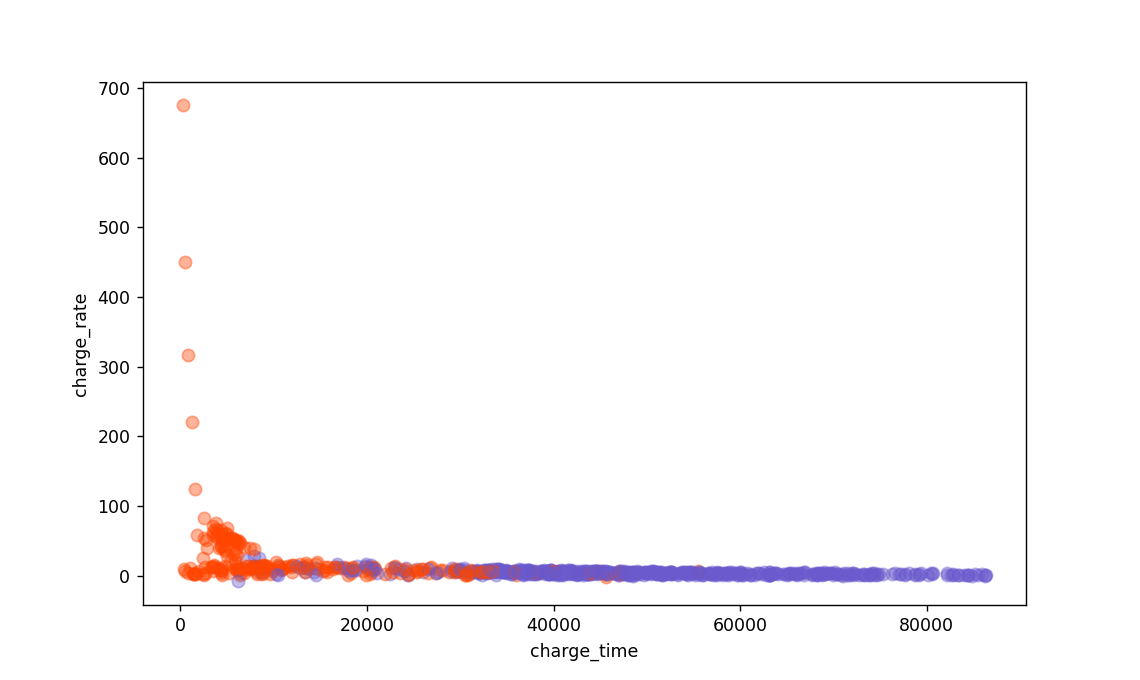

In [277]:
# 画示意图2D
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图
fig = plt.figure()
# ax = Axes3D(fig)
for  i in range(len(use_result)):
    if use_result.iloc[i,-1]==1:
        color1 = 'orangered'
    else:
        color1 = 'slateblue'
    area = np.pi * 4**2
    plt.scatter(use_result.iloc[i,-4],use_result.iloc[i,-3],color = color1,s=area,alpha=0.4)   #use_result.iloc[i,-2],
    plt.xlabel('charge_time')
    plt.ylabel('charge_rate')
#     ax.set_xlabel('charge_time', fontdict={'size': 15, 'color': 'black'})
#     ax.set_ylabel('charge_rate', fontdict={'size': 15, 'color': 'black'})
#     ax.set_zlabel('overnight', fontdict={'size': 15, 'color': 'black'})
plt.show()

<IPython.core.display.Javascript object>


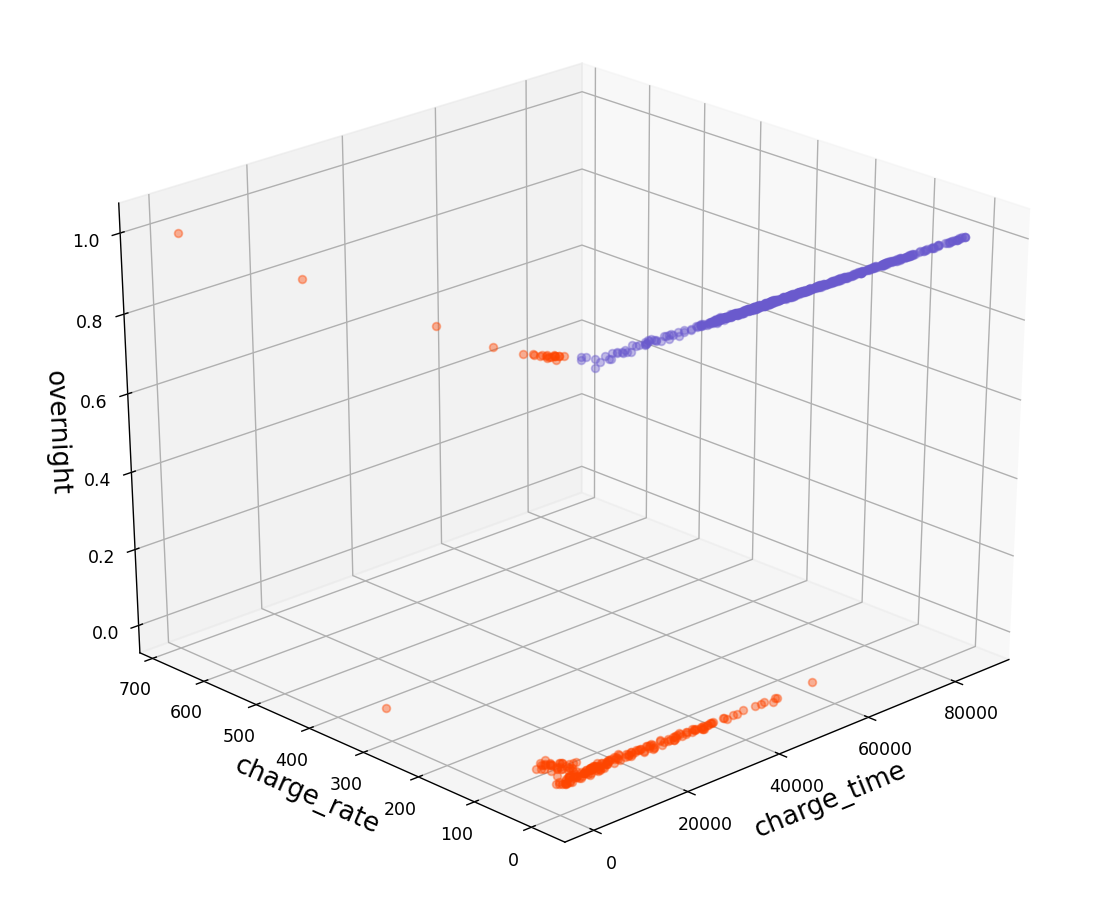

In [280]:
# 画示意图
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图
fig = plt.figure()
ax = Axes3D(fig)
for  i in range(len(use_result)):
    if use_result.iloc[i,-1]==1:
        color1 = 'orangered'
    else:
        color1 = 'slateblue'
    ax.scatter(use_result.iloc[i,-4],use_result.iloc[i,-3],use_result.iloc[i,-2],color = color1,alpha=0.4)  
    ax.set_xlabel('charge_time', fontdict={'size': 15, 'color': 'black'})
    ax.set_ylabel('charge_rate', fontdict={'size': 15, 'color': 'black'})
    ax.set_zlabel('overnight', fontdict={'size': 15, 'color': 'black'})
plt.show()

In [100]:
# 储存
use_result.to_csv('./file_save/kmeans2_result.csv')

In [202]:
# 公共桩充电行为数据
pri_car_pub = use_result[use_result['label']==1]
pri_car_pub = pri_car_pub.drop('label',axis = 1)
tt_charge_data = pd.concat([pri_car_pub,dataBpub],axis = 0)
tt_charge_data['label']=''
for i in range(len(tt_charge_data)):
    tt_charge_data.iloc[i,-1] = 1
tt_charge_data

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_time,charge_num,charge_rate,overnight,label
0,1,116666577,39744735,23333,7948,7,4440,14,11.351351,0,1
2,1,116667362,39744573,23333,7948,16,13500,40,10.666667,0,1
14,1,116661502,39749671,23332,7949,7,6000,15,9.000000,0,1
16,1,0,0,0,0,6,7620,21,9.921260,0,1
18,1,0,0,0,0,8,9300,26,10.064516,0,1
...,...,...,...,...,...,...,...,...,...,...,...
392,85,116691727,39500967,23338,7900,20,1860,17,32.903226,0,1
393,85,116692040,39498909,23338,7899,11,4620,31,24.155844,0,1
394,85,116569023,39746173,23313,7949,15,1920,39,73.125000,0,1
395,85,116319380,39788689,23263,7957,16,8640,60,25.000000,0,1


In [124]:
charge_time_distri = [0 for _ in range(24)]
for i in range(len(tt_charge_data)):
    index = int(tt_charge_data.iloc[i,4])
    charge_time_distri[index] += 1
charge_time_distri

[18,
 7,
 5,
 2,
 0,
 3,
 6,
 44,
 89,
 62,
 59,
 37,
 39,
 22,
 19,
 29,
 40,
 26,
 34,
 23,
 21,
 19,
 11,
 11]

In [153]:
charge_time_distri_5 = []
# 平均充电时间5h来算，加上时间因素

for i in range(24):
    if i+5 < 24:
        charge_time_distri_5.append(sum(charge_time_distri[i:i+5]))
    else:
        charge_time_distri_5.append(sum(charge_time_distri[i:24]) + sum(charge_time_distri[0:i+5-24]))
charge_time_distri_5

[32,
 17,
 16,
 55,
 142,
 204,
 260,
 291,
 286,
 219,
 176,
 146,
 149,
 136,
 148,
 152,
 144,
 123,
 108,
 85,
 80,
 66,
 52,
 43]

In [158]:
# 高峰小时系数
PHF = sum(charge_time_distri[8:13])/sum(charge_time_distri)
PHF 

0.45686900958466453

In [160]:
# print(max(charge_time_distri_5)/sum(charge_time_distri_5))

0.09297124600638977


<IPython.core.display.Javascript object>


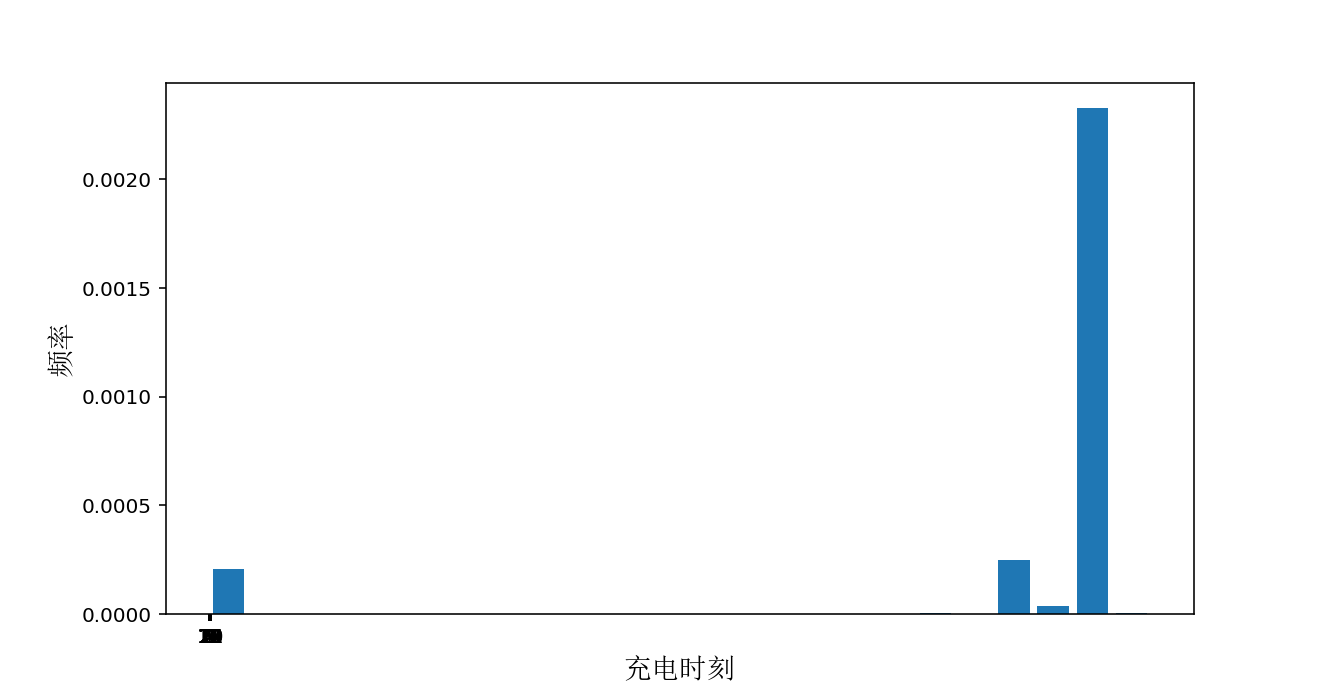

In [258]:
# 画分布图
plt.figure()
plt.hist(tt_charge_data.iloc[:,4],bins=24,rwidth=0.8,density=True)
# 坐标轴刻度
my_x_ticks = np.arange(0, 24, 1)
plt.xticks(my_x_ticks)
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc", size=14)
plt.xlabel(u"充电时刻", fontproperties=font)
plt.ylabel(u"频率", fontproperties=font)
plt.show()

对车进行聚类 - 投票法

In [203]:
# 对车辆用行为进行投票
pos_list = []   # point
vote0 = []   #label0个数
vote1 = []    #label1个数
for i in range(len(use_result)):
    point = (use_result.iloc[i][6],use_result.iloc[i][7])
    if point not in pos_list:
        pos_list.append(point)
        if use_result.iloc[i][3] == 0:
            vote0.append(1)
            vote1.append(0)
        else:
            vote0.append(0)
            vote1.append(1)
    else:
        index = pos_list.index(point)
        if use_result.iloc[i][3] == 0:
            vote0[index] += 1
        else:
            vote1[index] += 1

pos_result = []
for i in range(len(pos_list)):
    if vote0[i] > vote1[i]:
        pos_result.append(0)
    else:
        pos_result.append(1)

In [197]:
pos_result = []   #充电桩属性的结果
for i in range(len(pos_list)):
    if vote0[i] > vote1[i]:
        pos_result.append(0)   # 1-公共桩
    else:
        pos_result.append(1)   # 1-私人桩

计算需求占比

In [204]:
# 私人桩的充电行为数据
pri_car_pub = use_result[use_result['label']==0]
pri_car_pub

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_time,charge_num,charge_rate,overnight,label
1,1,116666442,39744834,23333,7948,19,46980,85,6.513410,1,0
3,1,116657451,39752795,23331,7950,20,48000,57,4.275000,1,0
4,1,116598465,39757418,23319,7951,20,45540,61,4.822134,1,0
5,1,116659156,39753026,23331,7950,21,40260,64,5.722802,1,0
6,1,116661424,39751002,23332,7950,19,44280,73,5.934959,1,0
...,...,...,...,...,...,...,...,...,...,...,...
829,86,116297102,38960928,23259,7792,19,40980,74,6.500732,1,0
831,86,116298247,38959435,23259,7791,23,27420,32,4.201313,1,0
835,86,116309231,38955232,23261,7791,22,35040,59,6.061644,1,0
836,86,116307487,38955817,23261,7791,16,63120,19,1.083650,1,0


In [205]:
# 所有公共桩的充电行为数据
tt_charge_data

,vid,lng,lat,convert_lng,convert_lat,start_hour,charge_time,charge_num,charge_rate,overnight,label
0,1,116666577,39744735,23333,7948,7,4440,14,11.351351,0,1
2,1,116667362,39744573,23333,7948,16,13500,40,10.666667,0,1
14,1,116661502,39749671,23332,7949,7,6000,15,9.000000,0,1
16,1,0,0,0,0,6,7620,21,9.921260,0,1
18,1,0,0,0,0,8,9300,26,10.064516,0,1
...,...,...,...,...,...,...,...,...,...,...,...
392,85,116691727,39500967,23338,7900,20,1860,17,32.903226,0,1
393,85,116692040,39498909,23338,7899,11,4620,31,24.155844,0,1
394,85,116569023,39746173,23313,7949,15,1920,39,73.125000,0,1
395,85,116319380,39788689,23263,7957,16,8640,60,25.000000,0,1


In [217]:
demand_pri = [0 for _ in range(87)]   #87辆车私人桩充电需求
for i in range(len(pri_car_pub)):
    index = pri_car_pub.iloc[i,0]
    demand_pri[index] += pri_car_pub.iloc[i,7]

demand_pub = [0 for _ in range(87)]   #87辆车公共桩充电需求   
for i in range(len(tt_charge_data)):
    index = tt_charge_data.iloc[i,0]
    demand_pub[index] += tt_charge_data.iloc[i,7]

<IPython.core.display.Javascript object>


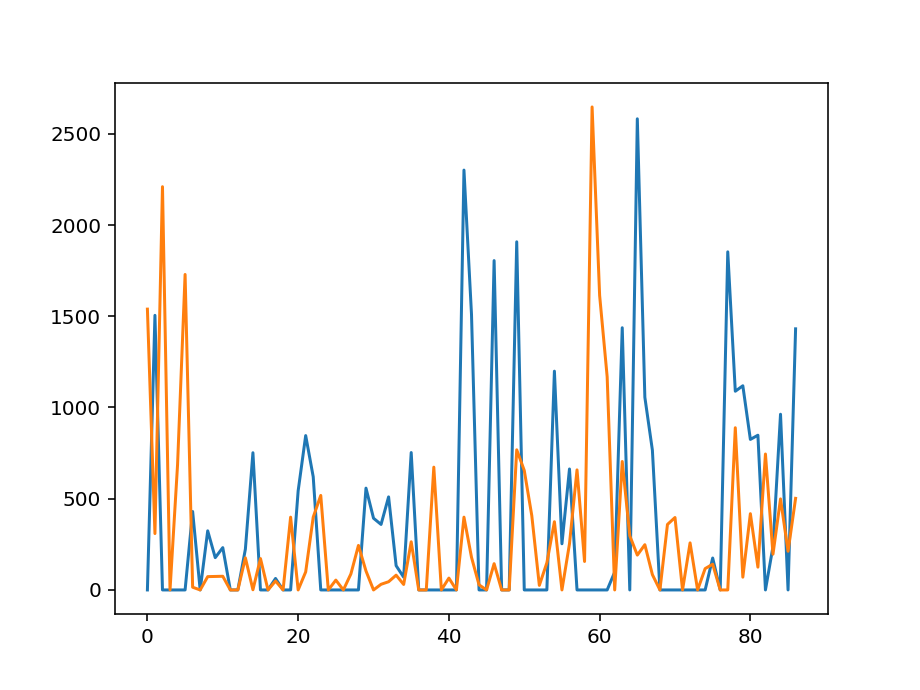

In [218]:
plt.figure()
plt.plot(demand_pri)
plt.plot(demand_pub)
plt.show()

In [262]:
demand_pri_rate = []
demand_pub_rate = []
name = []
for i in range(87):
#     if demand_pri[i] == 0 and demand_pub[i] == 0:
#         demand_pri_rate.append(0)
#         demand_pub_rate.append(0)
    if demand_pri[i] != 0 or demand_pub[i] != 0:
        mysum = demand_pri[i]+demand_pub[i]
        demand_pri_rate.append(demand_pri[i]/mysum)
        demand_pub_rate.append(demand_pub[i]/mysum)
        name.append(i)

<IPython.core.display.Javascript object>


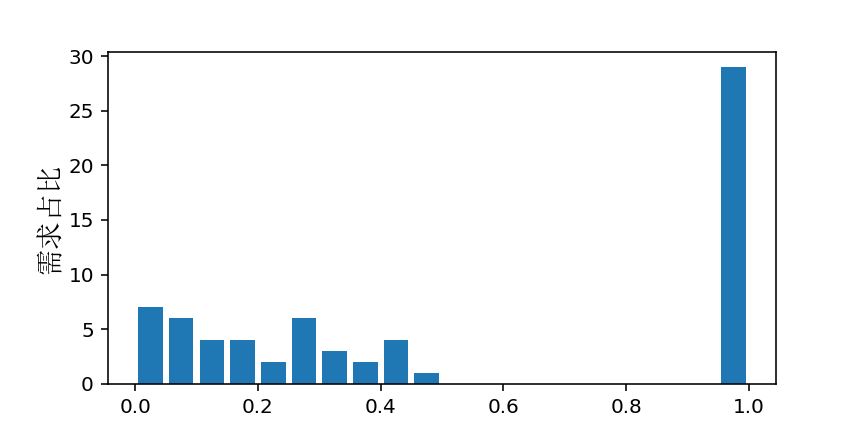

In [259]:
plt.figure(figsize=(6,3))
plt.hist(demand_pub_rate,bins = 20,rwidth=0.8, density=False)
# plt.plot(demand_pub_rate,label='public')   #label='private'
# plt.xlabel(u"车辆", fontproperties=font)
plt.ylabel(u"需求占比", fontproperties=font)
# plt.legend()
plt.show()

In [263]:
X = np.array([np.array(demand_pri_rate),np.array(demand_pub_rate),np.array(name)])
X = X.T
demand_output = pd.DataFrame(X)
demand_output.columns = ['pri_rate','pub_rate','id']
demand_output

,pri_rate,pub_rate,id
0,0.000000,1.000000,0.0
1,0.829658,0.170342,1.0
2,0.000000,1.000000,2.0
3,0.000000,1.000000,4.0
4,0.000000,1.000000,5.0
...,...,...,...
63,0.000000,1.000000,82.0
64,0.547344,0.452656,83.0
65,0.658687,0.341313,84.0
66,0.000000,1.000000,85.0


In [265]:
# 储存
demand_output.to_csv('./file_save/demand_output.csv')